# Treasury Bond Returns Summary

In [48]:
import sys
from pathlib import Path

sys.path.insert(0, "../../src")

import pandas as pd
#import polars as pl

from he_kelly_manela import pull_he_kelly_manela
from wrds_corp_bonds import pull_corp_bonds , calc_treasury_bond_returns
from settings import config

DATA_DIR = Path(config("DATA_DIR"))

# Treasury Bond Returns Summary

By leveraging the TRACE dataset from openbondassetpricing.com, the FTSFA dataset ensures a robust foundation for analyzing treasury bond returns, adhering to established methodologies and incorporating comprehensive data cleaning procedures.

## Data Cleaning and Construction

The treasury bond returns dataset is constructed using the following cleaning and processing steps:

### 1. Bond Selection Criteria

* **CUSIP Filtering**:
  * Only include bonds with CUSIPs starting with '91' (indicating Treasury securities)
  * This ensures we're only analyzing genuine Treasury bonds

### 2. Return Processing

* **Return Conversion**:
  * Convert raw returns to decimal form by dividing by 100
  * This standardizes the return format for analysis

* **Return Filtering**:
  * Remove observations where returns exceed 50% (tr_return > 0.5)
  * This eliminates potential data errors or extreme outliers

### 3. Maturity Grouping

* **Maturity Bins**:
  * Create 10 maturity groups using 0.5-year intervals from 0 to 5 years
  * Bins: [0.0, 0.5, 1.0, ..., 5.0]
  * Each group represents a specific maturity range for analysis

* **Group Assignment**:
  * Assign each bond to a maturity group based on its time to maturity (tau)
  * Drop observations with missing maturity information
  * Convert group labels to integers for easier analysis

### 4. Portfolio Construction

* **Return Aggregation**:
  * Group bonds by date and maturity group
  * Calculate mean returns for each group
  * This creates a time series of portfolio returns for each maturity group

### 5. Data Quality Checks

* **Missing Value Handling**:
  * Remove observations with missing returns
  * Remove observations with missing maturity group assignments

* **Outlier Treatment**:
  * Extreme returns (>50%) are filtered out
  * This ensures the analysis focuses on normal market conditions

This cleaning process ensures a high-quality dataset for analyzing Treasury bond returns across different maturity groups, facilitating comparison with the Kelly-Manzello data.

In [49]:
hkm = pull_he_kelly_manela.load_he_kelly_manela_all(data_dir=DATA_DIR / "he_kelly_manela")
treas_hkm = hkm.iloc[:,34:44].copy()
treas_hkm['yyyymm'] = hkm['yyyymm']
treas_hkm.head()
treas_hkm.tail()
treas_hkm.describe()
treas_hkm.isnull().sum()

US_bonds_01    25
US_bonds_02    25
US_bonds_03    25
US_bonds_04    25
US_bonds_05    25
US_bonds_06    25
US_bonds_07    25
US_bonds_08    25
US_bonds_09    25
US_bonds_10    25
yyyymm          0
dtype: int64

In [50]:
treas_bond_returns = calc_treasury_bond_returns.calc_treasury_bond_returns()

/Users/kausthubkeshava/ftsfa/src/wrds_corp_bonds/../../src/wrds_corp_bonds/calc_treasury_bond_returns.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bond_returns['tr_return'] = bond_returns['tr_return'] / 100


In [51]:
treas_bond_returns.describe()

,1,2,3,4,5,6,7,8,9,10
count,255.000000,254.000000,256.000000,256.000000,255.000000,257.000000,255.000000,257.000000,257.000000,257.000000
mean,0.001273,0.001316,0.001398,0.001493,0.001669,0.001879,0.002026,0.002066,0.002390,0.002437
std,0.001504,0.001913,0.002807,0.003794,0.004815,0.006027,0.007353,0.008611,0.009611,0.010555
min,-0.000596,-0.004275,-0.008214,-0.013675,-0.017838,-0.017558,-0.020857,-0.025805,-0.027687,-0.028776
25%,0.000169,0.000125,-0.000015,-0.000375,-0.000850,-0.001427,-0.002230,-0.002910,-0.003129,-0.003984
50%,0.000651,0.000607,0.000737,0.001029,0.001325,0.001504,0.001695,0.001982,0.001881,0.001381
75%,0.001873,0.002250,0.002513,0.003296,0.003664,0.004784,0.005637,0.006750,0.006922,0.007996
max,0.007029,0.011125,0.013801,0.016830,0.020866,0.023226,0.027240,0.024865,0.032687,0.030206


### Comparing FTSFA with He Kelly Manela 

HKM Treasury Bonds shape: (516, 12)
Treasury Bond Returns shape: (257, 10)

HKM Treasury Bonds date range: 0 to 515
Treasury Bond Returns date range: 20020831 to 20231231


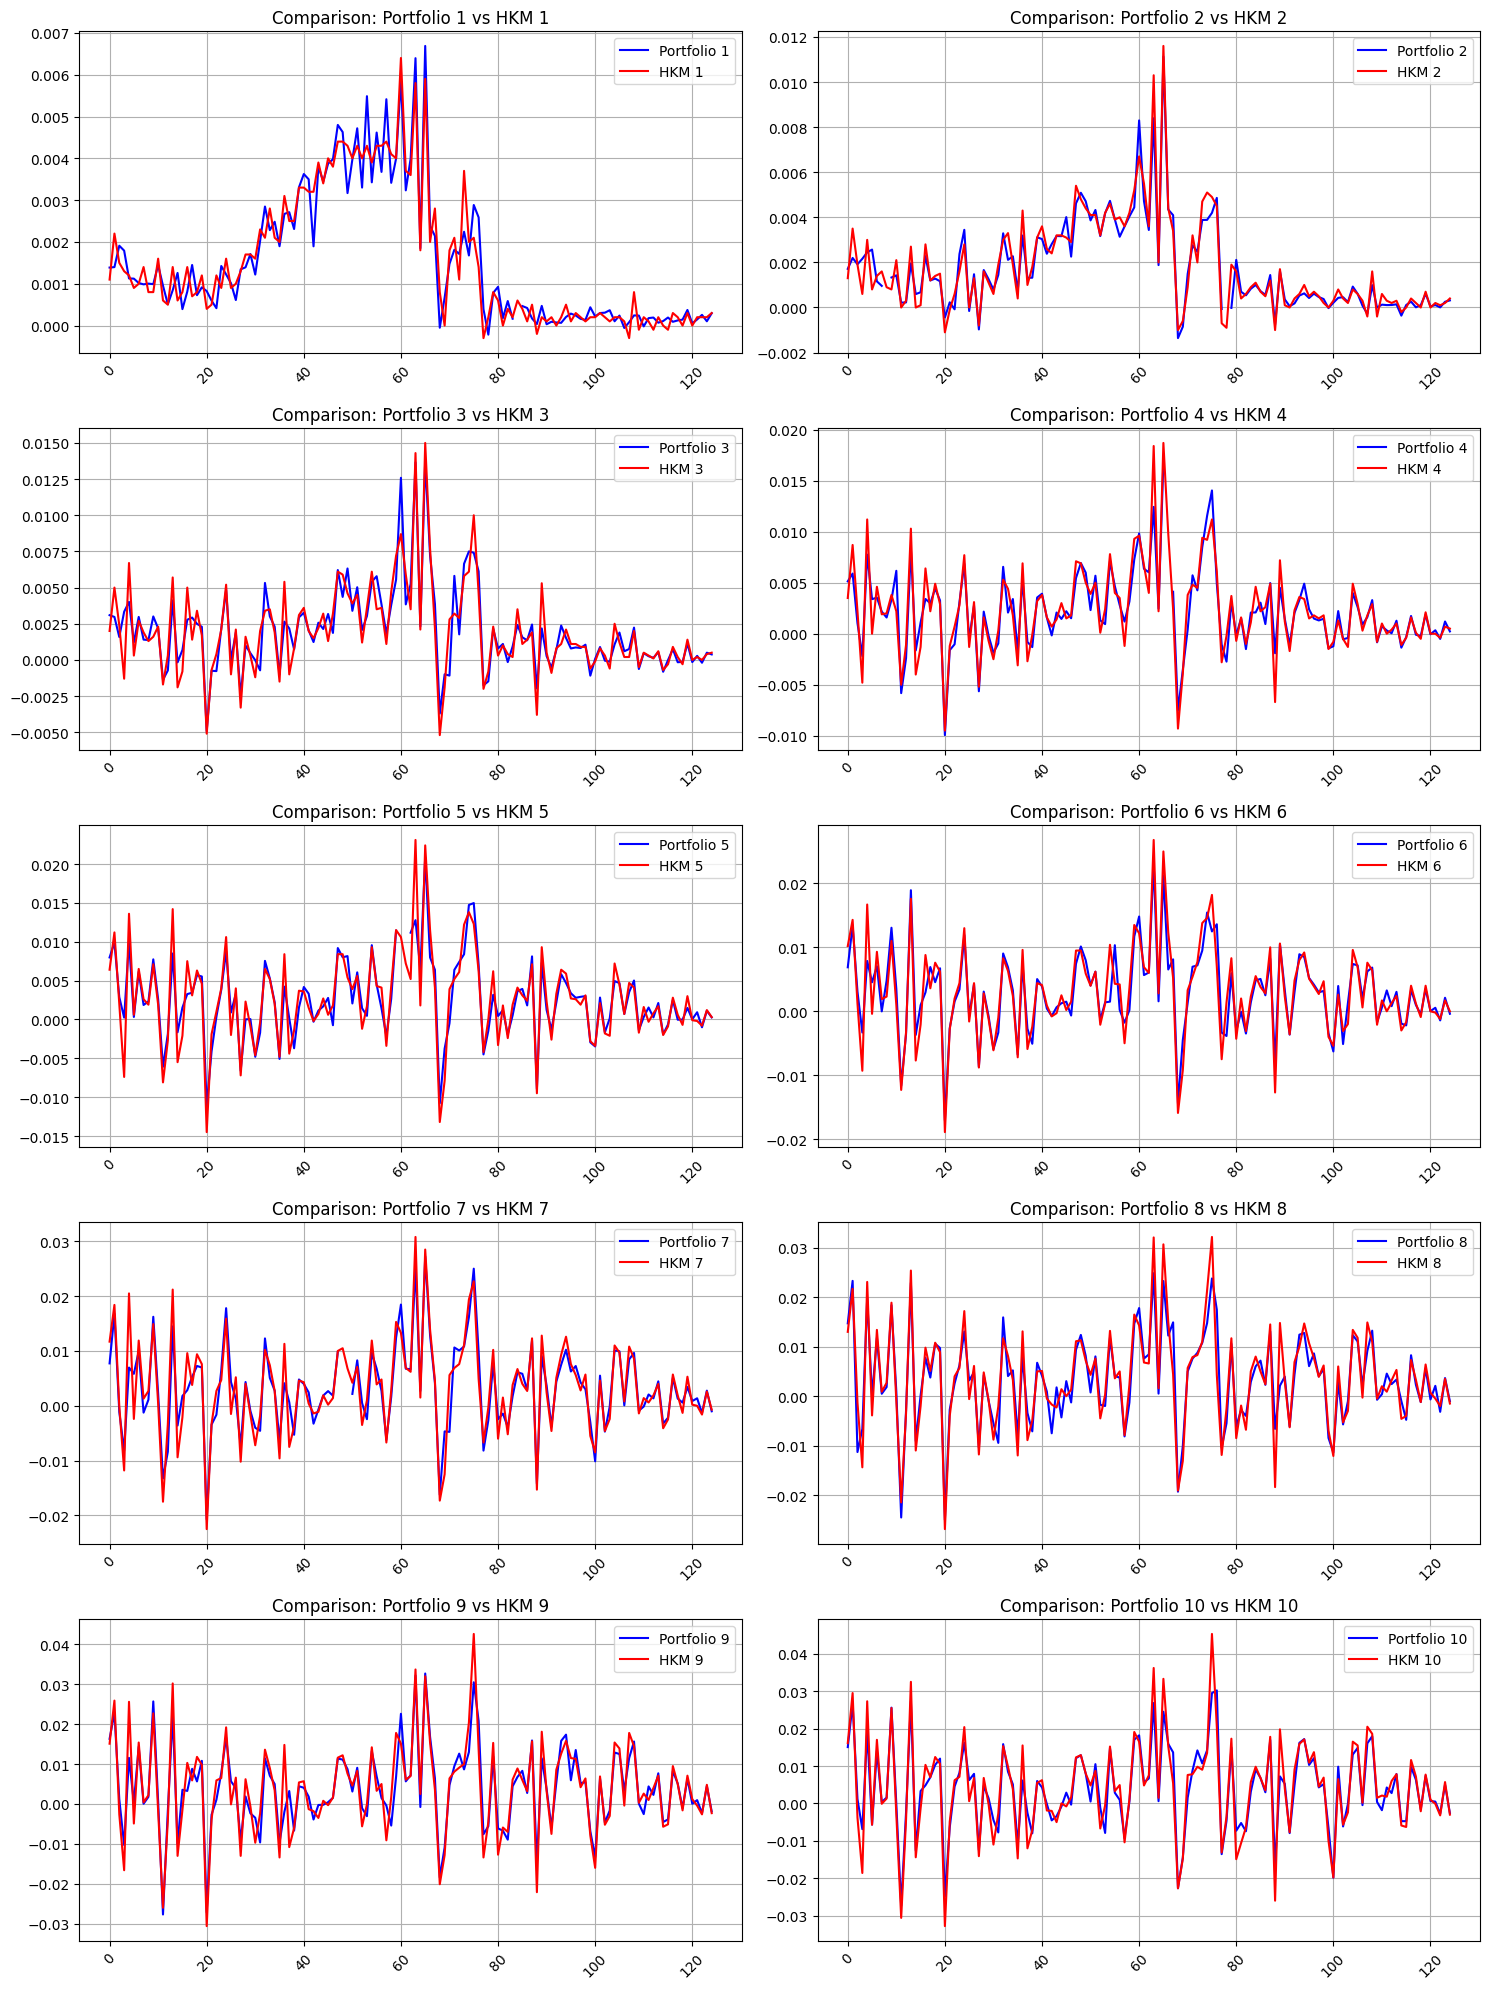


Correlations between corresponding columns:
Portfolio 1 vs HKM 1: 0.9607
Portfolio 2 vs HKM 2: 0.9646
Portfolio 3 vs HKM 3: 0.9096
Portfolio 4 vs HKM 4: 0.9375
Portfolio 5 vs HKM 5: 0.9235
Portfolio 6 vs HKM 6: 0.9355
Portfolio 7 vs HKM 7: 0.9320
Portfolio 8 vs HKM 8: 0.9344
Portfolio 9 vs HKM 9: 0.9318
Portfolio 10 vs HKM 10: 0.9555


In [52]:

treas_hkm['date'] = pd.to_datetime(treas_hkm['yyyymm'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0)
treas_hkm['date'] = treas_hkm['date'].dt.strftime('%Y%m%d').astype(int)
merged_df = pd.merge(treas_bond_returns, treas_hkm, left_on='DATE', right_on='date', how='inner')

# Now both DataFrames have datetime index with last day of month
print("HKM Treasury Bonds shape:", treas_hkm.shape)
print("Treasury Bond Returns shape:", treas_bond_returns.shape)

# Display the date ranges to verify alignment
print("\nHKM Treasury Bonds date range:", treas_hkm.index.min(), "to", treas_hkm.index.max())
print("Treasury Bond Returns date range:", treas_bond_returns.index.min(), "to", treas_bond_returns.index.max())

# Create subplots for each pair of columns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for i in range(10):
    col1 = str(i + 1)  # Column from treas_bond_returns
    if i == 9:
        col2 = f"US_bonds_10"  # Column from treas_hkm
    else:
        col2 = f"US_bonds_0{i + 1}"  # Column from treas_hkm
    
    ax = axes[i]
    ax.plot(merged_df.index, merged_df[col1], label=f'Portfolio {i+1}', color='blue')
    ax.plot(merged_df.index, merged_df[col2], label=f'HKM {i + 1}', color='red')
    ax.set_title(f'Comparison: Portfolio {i+1} vs HKM {i + 1}')
    ax.legend()
    ax.grid(True)
    
    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Print correlation between corresponding columns
print("\nCorrelations between corresponding columns:")
for i in range(10):
    col1 = str(i + 1)
    if i == 9:
        col2 = f"US_bonds_10" 
    else:
        col2 = f"US_bonds_0{i + 1}"
    corr = merged_df[col1].corr(merged_df[col2])
    print(f"Portfolio {i+1} vs HKM {i + 1}: {corr:.4f}")

---

### 📈 Comparison of Treasury Bond Portfolio Returns: FTSFA Portfolios vs. HKM Portfolios

The figure above compares the time-series returns of **Treasury bond portfolios**:

* **Portfolios 1–10** (in blue): Portfolios constructed by **FTSFA**, where Treasury bonds are sorted by **time remaining to maturity**, in 6-month intervals:

  * **Portfolio 1**: 0 to 6 months
  * **Portfolio 2**: 6 months to 1 year
  * **Portfolio 3**: 1 year to 1.5 years
  * **Portfolio 4**: 1.5 to 2 years
  * **Portfolio 5**: 2 to 2.5 years
  * **Portfolio 6**: 2.5 to 3 years
  * **Portfolio 7**: 3 to 3.5 years
  * **Portfolio 8**: 3.5 to 4 years
  * **Portfolio 9**: 4 to 4.5 years
  * **Portfolio 10**: 4.5 to 5 years

* **HKM Portfolios 1–10** (in red): Portfolios from **He, Kelly, and Manella (HKM)** using a similar 6-month maturity bucket structure for comparison.

---

### 🔍 Observations

* The returns between **FTSFA portfolios (blue)** and **HKM portfolios (red)** show **close alignment**, indicating a consistent term-structure pattern across both datasets.
* During periods of heightened volatility—such as the **2008 financial crisis** —portfolios with longer time to maturity generally exhibit greater return sensitivity, seen consistently in both series.
* Small return differences may result from:

  * Different data source used,
  * Differences in portfolio formation details or rebalance timing.

---

This comparison confirms that the **FTSFA replication tracks** the structure and return behavior of the HKM maturity-sorted Treasury portfolios.
